In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal import detrend

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[2]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from utils.noise_test import diagnose_series

In [2]:
initial_time = pd.to_datetime('2024-06-01T12:00:00+00:00')
final_time = pd.to_datetime('2025-01-01T12:00:00+00:00')

In [3]:
tickers = ["SPY", "TSLA", "NVDA", "BRK-B"]  # List of tickers
data_files = [os.path.join(data_path, f"{ticker}.parquet") for ticker in tickers]
data = {
    ticker: pd.read_parquet(path).loc[initial_time:final_time]
    for ticker, path in zip(tickers, data_files)
}
timeline = pd.DatetimeIndex(
    pd.to_datetime(sorted(set().union(*[df.index for df in data.values()])))
)
data = {tk: df.reindex(timeline).ffill() for tk, df in data.items()}
closing_data = {tk: df['adjClose'] for tk, df in data.items()}

In [4]:
for tk in tickers:
    print(tk)
    diagnose_series(data[tk]['adjClose'])
    print("\n==============")

SPY

Time Series Diagnostics Report
-------------------------------
Ljung-Box test (lag=20): stat=1664.530, p-value=0.000
Sample ACF (first 5 lags): [0.967, 0.932, 0.895, 0.859, 0.827]

TSLA

Time Series Diagnostics Report
-------------------------------
Ljung-Box test (lag=20): stat=1366.480, p-value=0.000
Sample ACF (first 5 lags): [0.972, 0.939, 0.904, 0.866, 0.828]

NVDA

Time Series Diagnostics Report
-------------------------------
Ljung-Box test (lag=20): stat=1189.624, p-value=0.000
Sample ACF (first 5 lags): [0.94, 0.892, 0.83, 0.776, 0.719]

BRK-B

Time Series Diagnostics Report
-------------------------------
Ljung-Box test (lag=20): stat=1510.114, p-value=0.000
Sample ACF (first 5 lags): [0.97, 0.937, 0.901, 0.864, 0.832]



<h1>Stack</h1>

In [5]:
from signal_modules._regressors._oracle_base import StackedOracle

In [29]:
from signal_modules._regressors.Kalman_filter import KalmanFilter
from signal_modules._regressors.FFT import FFTFilter

kalman1 = KalmanFilter(
    alpha=1,
    process_noise=1e-3,
    obs_noise_scale=1e+2
)
kalman2 = KalmanFilter(
    process_noise=1e-3,
    obs_noise_scale=1e+2
)
kalman3 = KalmanFilter(
    process_noise=1e-3,
    obs_noise_scale=1e+5
)

fft = FFTFilter(perc=.9, short_period_threshold=5)

In [30]:
stack = StackedOracle(
    oracles=[kalman1, fft, kalman3], 
    windows=[60, 40, 40], 
    weights=[1, 1, .8]
)

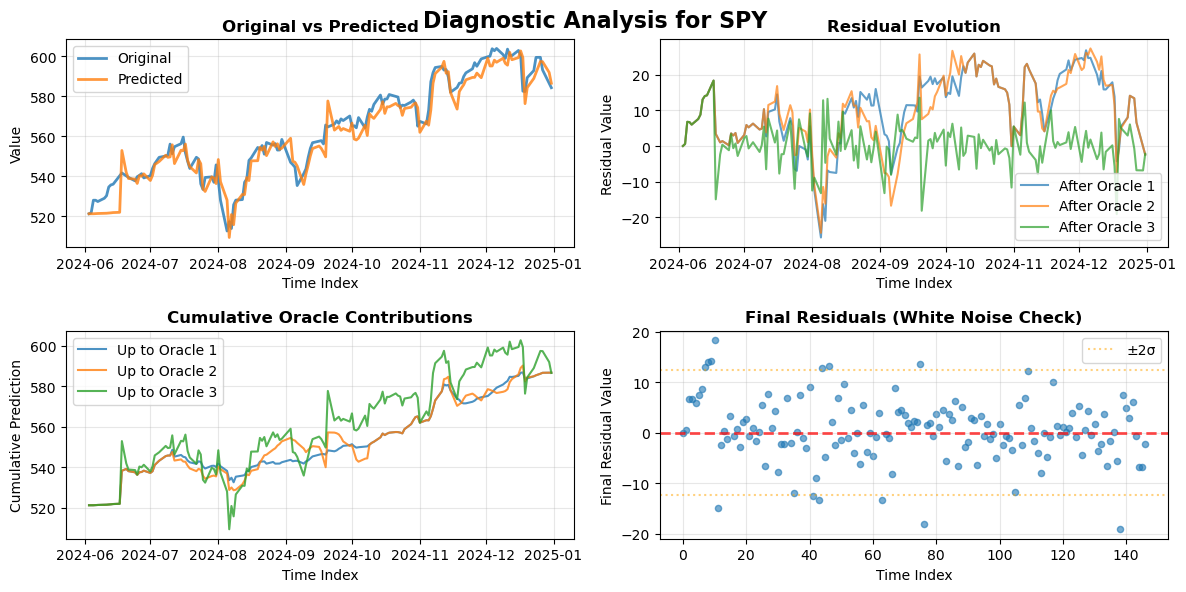

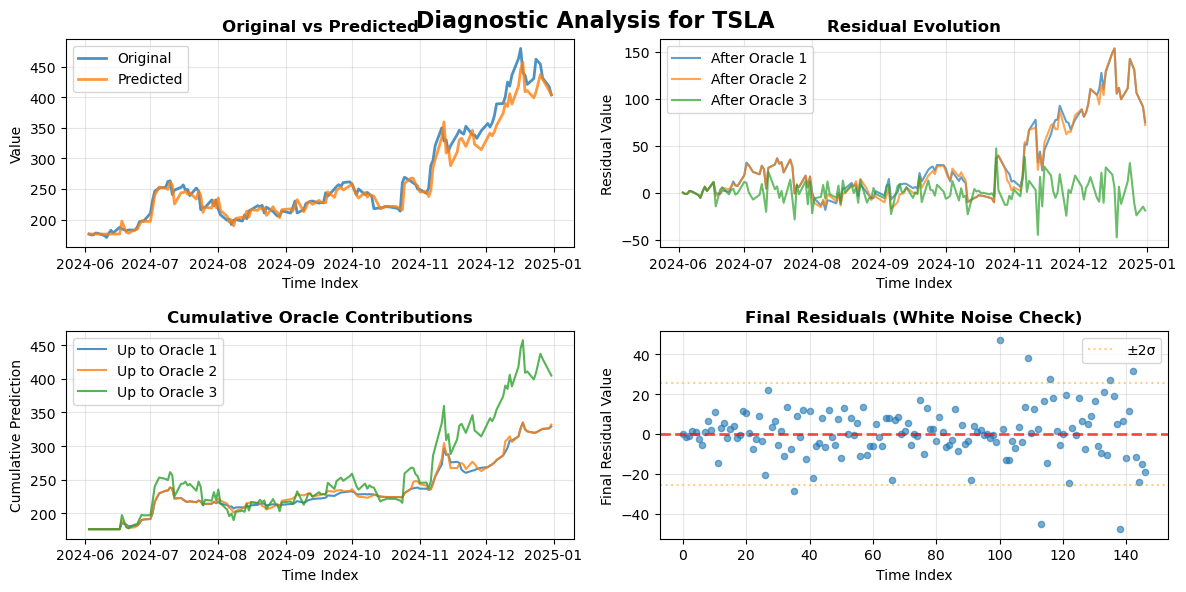

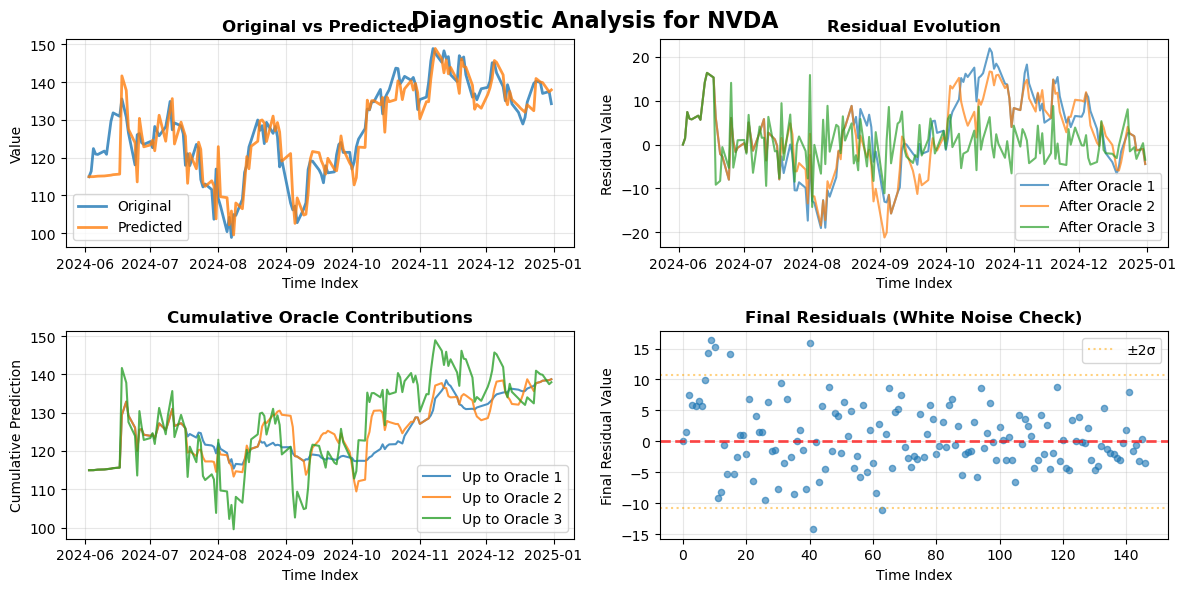

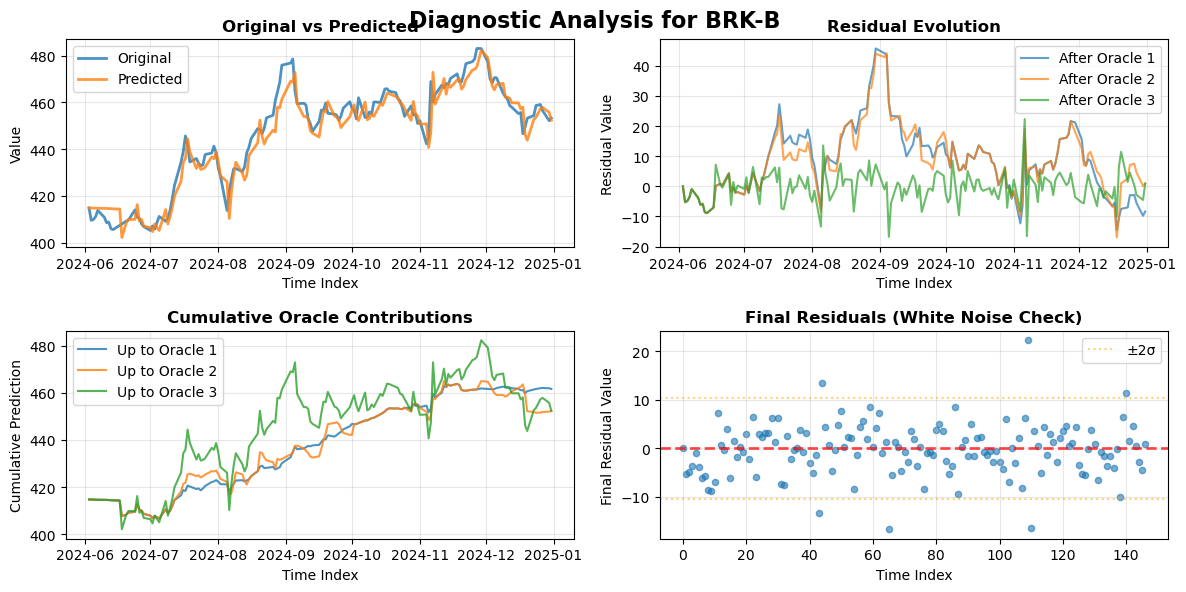

STACKED ORACLE PERFORMANCE ANALYSIS

SPY Performance Metrics:
  RMSE: 6.285461
  MAE:  4.914377
  R²:   0.930569
Ljung-Box Test (<0.05 => autocorr.): [0.964, 0.255, 0.43, 0.577, 0.653, 0.705, 0.642, 0.741, 0.707, 0.742, 0.708, 0.716, 0.624, 0.555, 0.63, 0.632, 0.683, 0.73, 0.784, 0.831, 0.87, 0.894, 0.919, 0.856, 0.878, 0.835, 0.853, 0.862, 0.891, 0.897, 0.813, 0.692, 0.731, 0.771, 0.804, 0.805]
  Shapiro-Wilk (Normality): FAIL (p-value: 0.019)
  Residual Mean: 0.517373
  Residual Std:  6.186423

TSLA Performance Metrics:
  RMSE: 15.324676
  MAE:  10.607623
  R²:   0.959388
Ljung-Box Test (<0.05 => autocorr.): [0.092, 0.238, 0.064, 0.06, 0.08, 0.071, 0.072, 0.111, 0.099, 0.123, 0.169, 0.225, 0.138, 0.183, 0.208, 0.227, 0.278, 0.322, 0.322, 0.283, 0.282, 0.208, 0.232, 0.232, 0.129, 0.16, 0.152, 0.184, 0.115, 0.141, 0.127, 0.15, 0.105, 0.077, 0.082, 0.098]
  Shapiro-Wilk (Normality): FAIL (p-value: 0.000)
  Residual Mean: 0.534900
  Residual Std:  12.876721

NVDA Performance Metrics:
  R

In [31]:
stack.diagnostics(data=closing_data)